In [29]:
DEBUG = True

## Đọc hình ảnh và split

In [30]:
from PIL import Image
import os

# === Config ===
image_path = "input_data/X_test/"  # Đường dẫn đến ảnh gốc
ROWS = 3
COLS = 5

def split_image(image_path, rows, cols):
    """Đọc ảnh và cắt thành rows x cols, trả về danh sách các mảnh."""
    img = Image.open(image_path)
    width, height = img.size

    piece_width = width // cols
    piece_height = height // rows

    pieces = []
    for r in range(rows):
        for c in range(cols):
            left = c * piece_width
            upper = r * piece_height
            right = left + piece_width
            lower = upper + piece_height
            piece = img.crop((left, upper, right, lower))
            pieces.append(piece)

    return pieces

def load_all_pieces(image_dir, rows, cols):
    """
    Duyệt toàn bộ ảnh trong thư mục và trả về mảng 3 chiều:
    all_pieces[image_index][row][col] = PIL.Image
    """
    all_pieces = []
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    )

    print(f"Found {len(image_files)} images in {image_dir}")

    for filename in image_files:
        image_path = os.path.join(image_dir, filename)
        print(f"- Processing {filename}...")
        pieces = split_image(image_path, rows, cols)
        all_pieces.append(pieces)

    print(f"\nTotal images processed: {len(all_pieces)}")
    return all_pieces

all_pieces = load_all_pieces(image_path, ROWS, COLS)
if DEBUG:
    all_pieces = all_pieces[:20]  # Giới hạn để debug nhanh

# Ví dụ: xem thông tin
print(f"Total images: {len(all_pieces)}")  # số lượng ảnh
if all_pieces:
    print(f"Rows per image: {len(all_pieces[0])}")


Found 100 images in input_data/X_test/
- Processing Alfred_Sisley_177_shuffled.jpg...
- Processing Alfred_Sisley_187_shuffled.jpg...
- Processing Alfred_Sisley_69_shuffled.jpg...
- Processing Amedeo_Modigliani_37_shuffled.jpg...
- Processing Andrei_Rublev_25_shuffled.jpg...
- Processing Andrei_Rublev_37_shuffled.jpg...
- Processing Andy_Warhol_119_shuffled.jpg...
- Processing Caravaggio_54_shuffled.jpg...
- Processing Caravaggio_7_shuffled.jpg...
- Processing Diego_Rivera_19_shuffled.jpg...
- Processing Edgar_Degas_108_shuffled.jpg...
- Processing Edgar_Degas_184_shuffled.jpg...
- Processing Edgar_Degas_189_shuffled.jpg...
- Processing Edgar_Degas_278_shuffled.jpg...
- Processing Edgar_Degas_299_shuffled.jpg...
- Processing Edgar_Degas_331_shuffled.jpg...
- Processing Edgar_Degas_340_shuffled.jpg...
- Processing Edgar_Degas_345_shuffled.jpg...
- Processing Edgar_Degas_462_shuffled.jpg...
- Processing Edgar_Degas_486_shuffled.jpg...
- Processing Edgar_Degas_502_shuffled.jpg...
- Process

In [31]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import random
import csv

# ===== CONFIG =====
OUTPUT_DIR = "output_data"
OUTPUT_IMG_DIR = os.path.join(OUTPUT_DIR, "output_images")
OUTPUT_HISTORY_DIR = os.path.join(OUTPUT_DIR, "output_history")  # NEW
INPUT_Y_CSV = "input_data/Y_test.csv"
ROWS = 3
COLS = 5

os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_HISTORY_DIR, exist_ok=True)

# ====== ADVANCED COST (non-DL, strong) ======
def _to_np_rgb(pil_img):
    return np.asarray(pil_img.convert("RGB"))

def _border_arrays(pieces):
    """Trích xuất viền (RGB) cho mỗi mảnh."""
    arrs = [_to_np_rgb(p) for p in pieces]
    tops    = [a[0, :, :]  for a in arrs]   # (W,3)
    bottoms = [a[-1, :, :] for a in arrs]   # (W,3)
    lefts   = [a[:, 0, :]  for a in arrs]   # (H,3)
    rights  = [a[:, -1, :] for a in arrs]   # (H,3)
    return tops, bottoms, lefts, rights

def _to_gray(x):
    return (0.299*x[...,0] + 0.587*x[...,1] + 0.114*x[...,2]).astype(np.float32)

def _grad_1d(vec):
    return np.abs(np.diff(vec, axis=0))

def _hist_cost(gray1, gray2, bins=16):
    h1, _ = np.histogram(gray1, bins=bins, range=(0,255), density=True)
    h2, _ = np.histogram(gray2, bins=bins, range=(0,255), density=True)
    denom = (h1 + h2) + 1e-9
    return 0.5 * np.sum(((h1 - h2)**2) / denom)

def _norm_color_cost(rgb1, rgb2):
    g1 = _to_gray(rgb1)
    g2 = _to_gray(rgb2)
    s1 = np.std(g1) + 1e-6
    s2 = np.std(g2) + 1e-6
    g1n = (g1 - np.mean(g1)) / s1
    g2n = (g2 - np.mean(g2)) / s2
    return np.sum(np.abs(g1n - g2n))

def _grad_cost(rgb1, rgb2):
    g1 = _to_gray(rgb1)
    g2 = _to_gray(rgb2)
    d1 = _grad_1d(g1)
    d2 = _grad_1d(g2)
    L = min(len(d1), len(d2))
    if L == 0:
        return 0.0
    return np.sum(np.abs(d1[:L] - d2[:L]))

def _mahalanobis_cost(rgb1, rgb2, cov_inv_3x3):
    diff = (rgb1.astype(np.float32) - rgb2.astype(np.float32)).reshape(-1, 3)
    return float(np.einsum('ij,jk,ik->i', diff, cov_inv_3x3, diff).sum())

def _cov_inv_rgb_from_all_borders(tops, bottoms, lefts, rights):
    all_pix = []
    for arrs in (tops, bottoms, lefts, rights):
        for b in arrs:
            all_pix.append(b.reshape(-1,3).astype(np.float32))
    X = np.concatenate(all_pix, axis=0)
    mu = X.mean(axis=0, keepdims=True)
    Xm = X - mu
    cov = (Xm.T @ Xm) / max(1, (Xm.shape[0]-1))
    cov += np.eye(3, dtype=np.float32)*1e-3
    cov_inv = np.linalg.inv(cov)
    return cov_inv

def compute_cost_matrix_advanced(pieces, w_color=0.3, w_grad=0.3, w_hist=0.2, w_maha=0.2, hist_bins=16):
    """
    Trả về H, V theo công thức:
    cost = w_color*ColorNorm + w_grad*Grad + w_hist*Hist + w_maha*Mahalanobis
    - H[i,j]: j bên phải i  (right(i) vs left(j))
    - V[i,j]: j bên dưới i (bottom(i) vs top(j))
    """
    n = len(pieces)
    H = np.zeros((n, n), dtype=np.float64)
    V = np.zeros((n, n), dtype=np.float64)

    tops, bottoms, lefts, rights = _border_arrays(pieces)
    cov_inv = _cov_inv_rgb_from_all_borders(tops, bottoms, lefts, rights)

    for i in range(n):
        r_i = rights[i]
        b_i = bottoms[i]
        for j in range(n):
            if i == j:
                continue
            l_j = lefts[j]
            t_j = tops[j]

            # Horizontal
            c_col  = _norm_color_cost(r_i, l_j)
            c_grad = _grad_cost(r_i, l_j)
            c_hist = _hist_cost(_to_gray(r_i), _to_gray(l_j), bins=hist_bins)
            c_maha = _mahalanobis_cost(r_i, l_j, cov_inv)
            H[i,j] = w_color*c_col + w_grad*c_grad + w_hist*c_hist + w_maha*c_maha

            # Vertical
            c_col  = _norm_color_cost(b_i, t_j)
            c_grad = _grad_cost(b_i, t_j)
            c_hist = _hist_cost(_to_gray(b_i), _to_gray(t_j), bins=hist_bins)
            c_maha = _mahalanobis_cost(b_i, t_j, cov_inv)
            V[i,j] = w_color*c_col + w_grad*c_grad + w_hist*c_hist + w_maha*c_maha

    # Normalize [0,1] (avoid skew)
    for M in (H, V):
        mask = (M > 0)
        if np.any(mask):
            mmin = M[mask].min()
            mmax = M[mask].max()
            if mmax > mmin:
                M[:,:] = (M - mmin) / (mmax - mmin + 1e-12)
    return H, V


# ===== GA CLASS =====
class GeneticAlgorithmPuzzleSolver:
    def __init__(self, rows, cols,
                 population_size=120, generations=300, mutation_rate=0.15,
                 elite_size=4, tournament_size=3,
                 w_color=0.3, w_grad=0.3, w_hist=0.2, w_maha=0.2, hist_bins=16,
                 # NEW:
                 p_block_crossover=0.5,           # xác suất dùng block crossover
                 num_block_children=4,            # số con tối đa/lần block-crossover
                 block_move_rate=0.15             # xác suất đột biến block move/swap
                 ):
        self.rows = rows
        self.cols = cols
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.tournament_size = tournament_size

        self.w_color = w_color
        self.w_grad  = w_grad
        self.w_hist  = w_hist
        self.w_maha  = w_maha
        self.hist_bins = hist_bins

        # NEW
        self.p_block_crossover = p_block_crossover
        self.num_block_children = num_block_children
        self.block_move_rate = block_move_rate

        self._last_history = None  # pd.DataFrame(gen,best,avg,worst)

    # ---------- utils ----------
    def _repair_permutation(self, chrom):
        """Đảm bảo chrom là hoán vị 0..N-1 (loại trùng/ngoài miền, chèn thiếu)."""
        n = self.rows * self.cols
        used = set()
        repaired = []
        for g in chrom:
            if isinstance(g, (int, np.integer)) and 0 <= g < n and g not in used:
                repaired.append(int(g)); used.add(int(g))
        missing = [x for x in range(n) if x not in used]
        repaired.extend(missing)
        return repaired[:n]

    def _chrom_to_grid(self, chrom):
        return np.array(chrom).reshape(self.rows, self.cols)

    def _grid_to_chrom(self, grid):
        return grid.reshape(-1).tolist()

    def _pick_block_spec(self):
        """Chọn khối: 40% hàng, 40% cột, 20% chữ nhật."""
        r, c = self.rows, self.cols
        rnd = random.random()
        if rnd < 0.4:
            h, w = 1, c
            r0 = random.randrange(r)
            c0 = 0
        elif rnd < 0.8:
            h, w = r, 1
            r0 = 0
            c0 = random.randrange(c)
        else:
            h = random.randrange(1, max(2, r))  # tránh full-grid
            w = random.randrange(1, max(2, c))
            r0 = random.randrange(r - h + 1)
            c0 = random.randrange(c - w + 1)
        return r0, c0, h, w

    def _extract_block_pieces(self, parent, r0, c0, h, w):
        g = self._chrom_to_grid(parent)
        return g[r0:r0+h, c0:c0+w].flatten().tolist()

    def _place_block_child(self, block_pieces, place_r0, place_c0, h, w, fill_parent):
        R, C = self.rows, self.cols
        if not (0 <= place_r0 <= R - h and 0 <= place_c0 <= C - w):
            return None
        child = -np.ones((R, C), dtype=int)
        it = iter(block_pieces)
        for rr in range(place_r0, place_r0+h):
            for cc in range(place_c0, place_c0+w):
                child[rr, cc] = next(it)
        used = set(block_pieces)
        for gene in fill_parent:
            if gene in used: continue
            pos = np.argwhere(child == -1)
            if pos.size == 0: break
            r1, c1 = pos[0]
            child[r1, c1] = gene
            used.add(gene)
        if (child == -1).any():
            return None
        return self._grid_to_chrom(child)

    # ---------- GA core ----------
    def create_population(self, total_pieces):
        base = list(range(total_pieces))
        return [random.sample(base, len(base)) for _ in range(self.population_size)]

    def fitness(self, chrom, H, V):
        total = 0.0
        grid = self._chrom_to_grid(chrom)
        for r in range(self.rows):
            for c in range(self.cols):
                cur = grid[r, c]
                if c < self.cols - 1:
                    total += H[cur, grid[r, c+1]]
                if r < self.rows - 1:
                    total += V[cur, grid[r+1, c]]
        return total

    def tournament_selection(self, population, fitnesses):
        selected = random.sample(list(zip(population, fitnesses)), self.tournament_size)
        return min(selected, key=lambda x: x[1])[0]

    # ---- Edge recombination (sửa để an toàn) ----
    def edge_crossover(self, parent1, parent2):
        parent1 = self._repair_permutation(parent1)
        parent2 = self._repair_permutation(parent2)
        size = len(parent1)
        all_genes = set(parent1) | set(parent2)
        adjacency = {g: set() for g in all_genes}

        def add_edges(p):
            L = len(p)
            for idx in range(L):
                cur = p[idx]
                left = p[idx - 1]
                right = p[(idx + 1) % L]
                adjacency[cur].add(left); adjacency[cur].add(right)

        add_edges(parent1); add_edges(parent2)

        current = random.choice(parent1)
        child = [current]
        while len(child) < size:
            for adj in adjacency.values():
                adj.discard(current)
            neigh = adjacency.get(current, set())
            if neigh:
                nxt = min(neigh, key=lambda k: len(adjacency.get(k, ())))
            else:
                remaining = [g for g in parent1 if g not in child]
                if not remaining:
                    remaining = [g for g in range(size) if g not in child]
                nxt = random.choice(remaining)
            child.append(nxt)
            current = nxt

        return self._repair_permutation(child)

    # ---- Block crossover (nhiều con, đặt top/bottom/left/right) ----
    def block_crossover_multi(self, parent1, parent2):
        src_parent = parent1 if random.random() < 0.5 else parent2
        src_parent = self._repair_permutation(src_parent)
        fill_parent = parent2 if src_parent == parent1 else parent1
        fill_parent = self._repair_permutation(fill_parent)

        r0, c0, h, w = self._pick_block_spec()
        block_pieces = self._extract_block_pieces(src_parent, r0, c0, h, w)

        R, C = self.rows, self.cols
        children = []
        if h <= R and w <= C:
            # TOP
            c_top = random.randrange(0, C - w + 1)
            ch = self._place_block_child(block_pieces, 0, c_top, h, w, fill_parent)
            if ch is not None: children.append(self._repair_permutation(ch))
            # BOTTOM
            c_bot = random.randrange(0, C - w + 1)
            ch = self._place_block_child(block_pieces, R - h, c_bot, h, w, fill_parent)
            if ch is not None: children.append(self._repair_permutation(ch))
            # LEFT
            r_left = random.randrange(0, R - h + 1)
            ch = self._place_block_child(block_pieces, r_left, 0, h, w, fill_parent)
            if ch is not None: children.append(self._repair_permutation(ch))
            # RIGHT
            r_right = random.randrange(0, R - h + 1)
            ch = self._place_block_child(block_pieces, r_right, C - w, h, w, fill_parent)
            if ch is not None: children.append(self._repair_permutation(ch))

        random.shuffle(children)
        return children[:self.num_block_children] if children else None

    # ---- Mutation (swap + block move) ----
    def _mutate_swap(self, chrom):
        new_chrom = chrom[:]
        i, j = random.sample(range(len(new_chrom)), 2)
        new_chrom[i], new_chrom[j] = new_chrom[j], new_chrom[i]
        return new_chrom

    def _mutate_block_move(self, chrom):
        R, C = self.rows, self.cols
        g = self._chrom_to_grid(chrom)

        mode = random.random()
        if mode < 0.4:     # 1 x k ngang
            h = 1
            w = random.randrange(2, max(3, C//2)+1) if C > 1 else 1
        elif mode < 0.8:   # k x 1 dọc
            h = random.randrange(2, max(3, R//2)+1) if R > 1 else 1
            w = 1
        else:              # 2 x 2 nếu được
            h = 2 if R >= 2 else 1
            w = 2 if C >= 2 else 1

        r0 = random.randrange(0, R - h + 1)
        c0 = random.randrange(0, C - w + 1)
        candidates = [(rr, cc) for rr in range(0, R - h + 1) for cc in range(0, C - w + 1)
                      if not (rr == r0 and cc == c0)]
        if not candidates:
            return chrom[:]
        r1, c1 = random.choice(candidates)
        src = g[r0:r0+h, c0:c0+w].copy()
        dst = g[r1:r1+h, c1:c1+w].copy()
        g[r0:r0+h, c0:c0+w] = dst
        g[r1:r1+h, c1:c1+w] = src
        return self._grid_to_chrom(g)

    def mutate(self, chrom):
        out = chrom[:]
        if random.random() < self.block_move_rate:
            out = self._mutate_block_move(out)
        if random.random() < self.mutation_rate:
            out = self._mutate_swap(out)
        return self._repair_permutation(out)

    # ----- Main GA Process -----
    def run(self, pieces):
        """Trả về (best_order, best_fitness); đồng thời lưu lịch sử vào self._last_history."""
        total_pieces = self.rows * self.cols
        H, V = compute_cost_matrix_advanced(
            pieces,
            w_color=self.w_color, w_grad=self.w_grad,
            w_hist=self.w_hist, w_maha=self.w_maha,
            hist_bins=self.hist_bins
        )
        population = self.create_population(total_pieces)
        population = [self._repair_permutation(ind) for ind in population]

        history = {"gen": [], "best": [], "avg": [], "worst": []}

        for gen in tqdm(range(self.generations), desc="GA evolving", leave=False):
            fitnesses = [self.fitness(ind, H, V) for ind in population]
            history["gen"].append(gen + 1)
            history["best"].append(float(np.min(fitnesses)))
            history["avg"].append(float(np.mean(fitnesses)))
            history["worst"].append(float(np.max(fitnesses)))

            new_population = []
            sorted_pairs = sorted(zip(fitnesses, population), key=lambda x: x[0])
            elites = [p for _, p in sorted_pairs[:self.elite_size]]
            new_population.extend(elites)

            while len(new_population) < self.population_size:
                p1 = self.tournament_selection(population, fitnesses)
                p2 = self.tournament_selection(population, fitnesses)

                children_batch = None
                if random.random() < self.p_block_crossover:
                    children_batch = self.block_crossover_multi(p1, p2)

                if children_batch:
                    for ch in children_batch:
                        ch = self.mutate(ch)
                        new_population.append(ch)
                        if len(new_population) >= self.population_size:
                            break
                else:
                    child = self.edge_crossover(p1, p2)
                    child = self.mutate(child)
                    new_population.append(child)

            population = new_population[:self.population_size]

        final_fits = [self.fitness(ind, H, V) for ind in population]
        best_idx = int(np.argmin(final_fits))
        self._last_history = pd.DataFrame(history)
        return population[best_idx], float(final_fits[best_idx])

    # ----- Assemble final image -----
    def assemble_image(self, pieces, order):
        grid = self._chrom_to_grid(order)
        w, h = pieces[0].size
        out = Image.new("RGB", (w*self.cols, h*self.rows))
        for r in range(self.rows):
            for c in range(self.cols):
                out.paste(pieces[grid[r, c]], (c*w, r*h))
        return out


# ===== Runner =====
class PuzzleRunner:
    def __init__(self, ga_solver, pieces_list, image_dir, output_dir, output_img_dir, y_true_csv):
        self.ga_solver = ga_solver
        self.pieces_list = pieces_list
        self.image_dir = image_dir
        self.output_dir = output_dir
        self.output_img_dir = output_img_dir
        self.y_true_csv = y_true_csv

    def run_all(self):
        results = []
        image_files = sorted([f for f in os.listdir(self.image_dir)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        for idx, pieces in enumerate(tqdm(self.pieces_list, desc="Running GA for images")):
            best_order, _ = self.ga_solver.run(pieces)   # best_order: o->c
            image_name = image_files[idx]

            # Lưu ảnh lắp theo o->c (không đổi)
            img = self.ga_solver.assemble_image(pieces, best_order)
            img.save(os.path.join(self.output_img_dir, f"{image_name}_solved.png"))

            # NEW: lưu lịch sử fitness theo thế hệ cho ảnh này
            hist_df = getattr(self.ga_solver, "_last_history", None)
            if isinstance(hist_df, pd.DataFrame) and not hist_df.empty:
                safe_name = image_name.replace("/", "_")
                hist_path = os.path.join(OUTPUT_HISTORY_DIR, f"{safe_name}__fitness_history.csv")
                hist_df.to_csv(hist_path, index=False)

            # ĐỔI HỆ QUY CHIẾU: o->c --> c->o  (khớp Y_test.csv)
            n = self.ga_solver.rows * self.ga_solver.cols
            pred_c2o = [0] * n
            for o, c in enumerate(best_order):
                pred_c2o[c] = o
            results.append([image_name] + pred_c2o)

        # Save CSV theo c->o
        output_csv = os.path.join(self.output_dir, "output.csv")
        with open(output_csv, "w", newline="") as f:
            writer = csv.writer(f)
            header = ["image_filename"] + [
                f"piece_at_{r}_{c}" for r in range(self.ga_solver.rows) for c in range(self.ga_solver.cols)
            ]
            writer.writerow(header)
            writer.writerows(results)

        print(f"Saved output to {output_csv}")
        print(f"Solved images saved to {self.output_img_dir}")
        print(f"Per-image fitness histories saved to {OUTPUT_HISTORY_DIR}")
        return output_csv

    def evaluate(self, output_csv):
        df_pred = pd.read_csv(output_csv)
        df_true = pd.read_csv(self.y_true_csv)

        correct_count = 0
        ppa_scores = []

        true_map = {row['image_filename']: row.values[1:].astype(int)
                    for _, row in df_true.iterrows()}

        for _, row in df_pred.iterrows():
            fname = row['image_filename']
            if fname not in true_map:
                continue
            pred = row.values[1:].astype(int)  # c->o
            gt   = true_map[fname]             # c->o

            if np.array_equal(pred, gt):
                correct_count += 1
            ppa_scores.append((pred == gt).sum() / len(gt))

        total = len(df_true)
        acc = (correct_count / total) * 100 if total else 0.0
        mean_ppa = float(np.mean(ppa_scores)) if ppa_scores else 0.0

        print(f"\nTotal images: {total}")
        print(f"Correctly solved: {correct_count}/{total} ({acc:.2f}%)")
        print(f"Average PPA: {mean_ppa:.4f}")


In [32]:
ga_solver = GeneticAlgorithmPuzzleSolver(
    rows=ROWS, cols=COLS,
    population_size=100, generations=500, mutation_rate=0.3,
    elite_size=3, tournament_size=3,
    w_color=0.3, w_grad=0.3, w_hist=0.2, w_maha=0.2, hist_bins=16,
    p_block_crossover=0.5,      # dùng block ~50% lượt giao phối
    num_block_children=4,       # top/bottom/left/right
    block_move_rate=0.15        # tỉ lệ đột biến khối
)


runner = PuzzleRunner(
    ga_solver=ga_solver,
    pieces_list=all_pieces,
    image_dir=image_path,
    output_dir=OUTPUT_DIR,
    output_img_dir=OUTPUT_IMG_DIR,
    y_true_csv=INPUT_Y_CSV
)

out_csv = runner.run_all()
runner.evaluate(out_csv)


Running GA for images: 100%|██████████| 20/20 [04:36<00:00, 13.85s/it]

Saved output to output_data\output.csv
Solved images saved to output_data\output_images
Per-image fitness histories saved to output_data\output_history

Total images: 100
Correctly solved: 5/100 (5.00%)
Average PPA: 0.4533


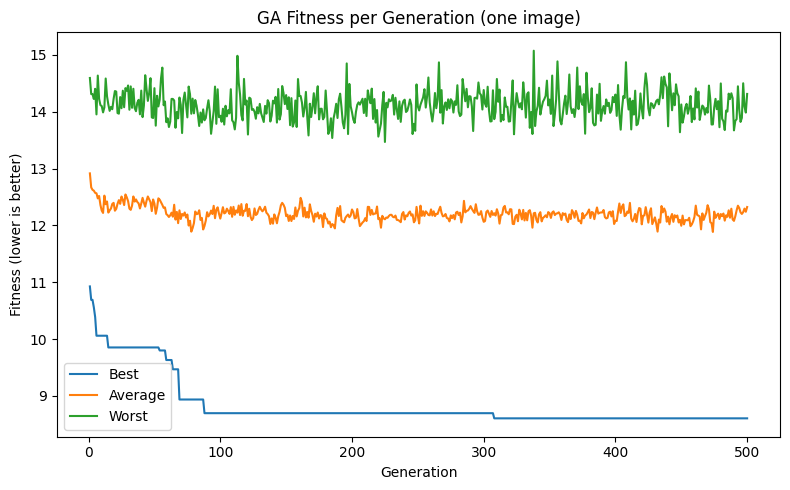

Best fitness: 8.606731488255928


,gen,best,avg,worst
0,1,10.926816,12.914874,14.592929
1,2,10.690467,12.668428,14.310039
2,3,10.690467,12.625958,14.307472
3,4,10.558096,12.611048,14.223840
4,5,10.388463,12.572194,14.402453


In [33]:
# Fallback: nếu `all_pieces` chưa tồn tại thì build từ thư mục ảnh
import os
from PIL import Image

def slice_image_uniform(img_path, rows, cols):
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    pw, ph = w // cols, h // rows
    pieces = []
    for r in range(rows):
        for c in range(cols):
            left = c * pw
            upper = r * ph
            right = left + pw
            lower = upper + ph
            pieces.append(img.crop((left, upper, right, lower)))
    return pieces

def build_all_pieces(image_dir, rows, cols, exts=(".png",".jpg",".jpeg")):
    files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(exts)])
    out = []
    for f in files:
        out.append(slice_image_uniform(os.path.join(image_dir, f), rows, cols))
    return out, files

# Ưu tiên dùng `all_pieces` có sẵn; nếu không có thì build từ runner.image_dir hoặc mặc định
if 'all_pieces' in globals():
    pass
elif 'runner' in globals():
    all_pieces, image_files = build_all_pieces(runner.image_dir, ga_solver.rows, ga_solver.cols)
else:
    default_dir = "input_data/X_test"
    all_pieces, image_files = build_all_pieces(default_dir, ga_solver.rows, ga_solver.cols)

len(all_pieces), (len(all_pieces[0]) if all_pieces else 0)


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def run_ga_with_history(ga_solver, pieces):
    """
    Giống ga_solver.run(pieces) nhưng ghi lại best/avg/worst mỗi thế hệ.
    Trả về: best_order, best_fitness, hist_df(gen,best,avg,worst).
    """
    rows, cols = ga_solver.rows, ga_solver.cols
    H, V = compute_cost_matrix_advanced(
        pieces,
        w_color=ga_solver.w_color, w_grad=ga_solver.w_grad,
        w_hist=ga_solver.w_hist, w_maha=ga_solver.w_maha,
        hist_bins=ga_solver.hist_bins
    )

    population = ga_solver.create_population(rows * cols)
    history = {"gen": [], "best": [], "avg": [], "worst": []}

    for gen in tqdm(range(ga_solver.generations), desc="GA evolving (history)", leave=False):
        fitnesses = [ga_solver.fitness(ind, H, V) for ind in population]
        history["gen"].append(gen + 1)
        history["best"].append(float(np.min(fitnesses)))
        history["avg"].append(float(np.mean(fitnesses)))
        history["worst"].append(float(np.max(fitnesses)))

        # Elitism + tournament + edge crossover + swap mutation (giữ nguyên logic của bạn)
        new_population = []
        sorted_pop = [x for _, x in sorted(zip(fitnesses, population), key=lambda x: x[0])]
        new_population.extend(sorted_pop[:ga_solver.elite_size])
        while len(new_population) < ga_solver.population_size:
            p1 = ga_solver.tournament_selection(population, fitnesses)
            p2 = ga_solver.tournament_selection(population, fitnesses)
            child = ga_solver.edge_crossover(p1, p2)
            child = ga_solver.mutate(child)
            new_population.append(child)
        population = new_population

    final_fits = [ga_solver.fitness(ind, H, V) for ind in population]
    best_idx = int(np.argmin(final_fits))
    best_order = population[best_idx]
    best_fit = float(final_fits[best_idx])
    return best_order, best_fit, pd.DataFrame(history)

# ---- Chạy test cho 1 ảnh (ví dụ: ảnh đầu tiên) ----
test_index = 0
pieces = all_pieces[test_index]

best_order, best_fit, hist_df = run_ga_with_history(ga_solver, pieces)

# ---- Vẽ 1 biểu đồ với 3 đường best/avg/worst ----
plt.figure(figsize=(8,5))
plt.plot(hist_df["gen"], hist_df["best"], label="Best")
plt.plot(hist_df["gen"], hist_df["avg"], label="Average")
plt.plot(hist_df["gen"], hist_df["worst"], label="Worst")
plt.xlabel("Generation")
plt.ylabel("Fitness (lower is better)")
plt.title("GA Fitness per Generation (one image)")
plt.legend()
plt.tight_layout()
plt.show()

# (Tuỳ chọn) Lưu CSV lịch sử và xem nhanh vài dòng
hist_df.to_csv("ga_fitness_history_one_image.csv", index=False)
print("Best fitness:", best_fit)
hist_df.head()
